In [200]:
%run ./tools.ipynb

In [201]:
month_strings = []
for i in range(1,13): month_strings.append(short_name_of_month(i))

In [202]:
mode = 'N'
top_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/'
mod_dir = top_dir + 'CO2-2018/nd51/'
monthly_adjustment = []

In [203]:
np.set_printoptions(suppress=True)
mes_err = 0.5
mod_err = 0.5
prior_err = 0.05

for imonth in range(1,13):

    name_month = short_name_of_month(imonth)
    ens_dir = top_dir + 'CO2-2018-' + month_string(imonth) + '/nd51/'
    
    if mode == 'N':
        delta_y0_file = 'delta_y0_model_N_' + str(imonth) + '.nc'
        xco2_file = 'XCO2_mod_and_oco2_N_' + name_month + '.nc'
    else:
        delta_y0_file = 'delta_y0_model_' + str(imonth) + '.nc'
        xco2_file = 'XCO2_mod_and_oco2_' + name_month + '.nc'
    # open datasets
    # ensemble runs
    ds_delta_y0 = xr.open_dataset(ens_dir + delta_y0_file)
    varnames = list(ds_delta_y0.data_vars.keys())  # list of variable name
    needed_vars = [i for i in varnames if i.startswith('X_SpeciesConc_CO2Tag')] # species var names
    # one-year run
    ds_xco2 = xr.open_dataset(mod_dir + xco2_file)
    xco2_oco2  = ds_xco2['xco2_oco2']
    xco2_model = ds_xco2['xco2_model']
    xco2_error = ds_xco2['xco2_error']
    diff = ds_xco2['xco2_oco2'] - ds_xco2['xco2_model']
    # reduce the size of all arrays and matrices, from 400k to <10k
    x = xco2_oco2.copy()
    x = x[np.logical_not(np.isnan(x))]
    ind = x.record.values   # index for slicing
    length = len(ind)
    # get a slice of arrays
    diff_slice = diff[ind].values            # [nobs], 1-3k per month
    xco2_error_slice = xco2_error[ind].values

    
    if imonth == 1:
        # a priori error                # full representation
        del_X_f = np.zeros((22,22))     # ne = nx, [nx, nx], what are my ensemble members?
        for idiag in range(22):
            del_X_f[idiag,idiag] = prior_err  # assumed to be 1 PgC/yr
        # delta y0
        del_Y = np.empty((length,22))   # [nobs, ne]
        del_Y[:] = np.nan
        for itag, ivar in enumerate(needed_vars):
            del_Y[:,itag] = ds_delta_y0[ivar][ind].values 
        
        # PROBLEM! SOLVED
        #print('del_y: ', np.amax(del_Y), np.amin(del_Y))
        #diff2 = del_Y[:,12] - del_Y[:,1]
        #plt.plot(diff2)
        #cx = plt.cm.jet
        #plt.pcolormesh(del_Y, cmap = cx)
        #plt.colorbar()
        #plt.show()
        
        # observation error
        obs_error = np.zeros((length,length))  # [nobs,nobs], diagonally store obs error
        for idiag in range(length):
            #obs_error[idiag, idiag] = mes_err**2 + mod_err**2  # 2.5**2! 2.5 is too large, first error < 1 
            obs_error[idiag, idiag] = xco2_error_slice[idiag]**2 + mod_err**2  # 2.5**2! 2.5 is too large, first error < 1 
            # measurment error from oco2
            # model error and representation error = 2.5 for land
        # calculation of first posterior
        del_Y_tran = np.matrix.transpose(del_Y)     # del_y transpose [ne,nobs]
        first      = np.matmul(del_Y,del_Y_tran)    # del_y dot del_y_tran [nobs,nobs]
        second     = np.linalg.inv(first+obs_error) # (Y*Yt + R)^-1 [nobs,nobs]
        third      = np.matmul(del_Y_tran,second)   # Yt*(Y*Yt + R)^-1 [ne,nobs]
        k_e        = np.matmul(del_X_f,third)       # kalman gain, k_e = X_f*Yt*(Y*Yt + R)^-1 [ne,nobs]
        adjust     = np.matmul(k_e, diff_slice)     # adjustment to prior, k_e*(yobs - ym)  [ne]
        print(short_name_of_month(imonth), ': {:f}'.format(sum(adjust)))
        monthly_adjustment.append(sum(adjust))
        # transformation matrix to use next
        fourth = np.identity(22) - np.matmul(third, del_Y)
        transform_mat = sp.sqrtm(fourth)
        
    else:
        # update del_X_f
        del_X_a = np.matmul(del_X_f, transform_mat)
        del_X_f = del_X_a.copy()
    
        del_X_f_inv = np.linalg.inv(del_X_f)
        update = np.matmul(del_X_f_inv, del_X_f)
        # delta y0
        del_Y = np.empty((length,22))
        del_Y[:] = np.nan
        
        for itag, ivar in enumerate(needed_vars):
            del_Y[:,itag] = ds_delta_y0[ivar][ind].values
        #print('del_Y: ', del_Y)
        #cx = plt.cm.jet
        #plt.pcolormesh(del_Y, cmap = cx)
        #plt.colorbar()
        #plt.show()
        
        # observation error
        obs_error = np.zeros((length,length))
        for idiag in range(length):
            obs_error[idiag, idiag] = xco2_error_slice[idiag]**2 + mod_err**2
            #obs_error[idiag, idiag] = mes_err**2 + mod_err**2
            # measurment error from oco2
            # model error and representation error = 2.5 for land
        
        # calculation of posterior
        del_Y_tran = np.matrix.transpose(del_Y)
        first      = np.matmul(del_Y,del_Y_tran)
        second     = np.linalg.inv(first+obs_error)
        third      = np.matmul(del_Y_tran,second)
        k_e        = np.matmul(del_X_f,third)   # kalman gain,
        adjust     = np.matmul(k_e, diff_slice) # adjustment to prior
        print(short_name_of_month(imonth), ': {:f}'.format(sum(adjust)))
        monthly_adjustment.append(sum(adjust))
        # transformation matrix to use in next cycle
        fourth = np.identity(22) - np.matmul(third, del_Y)
        transform_mat = sp.sqrtm(fourth)
        

Jan : -0.877851
Feb : -0.510311
Mar : -0.081689
Apr : -0.055155
May : 0.118579
Jun : 0.332626
Jul : 0.396277
Aug : 0.088095
Sep : 0.132515
Oct : 0.171906
Nov : 0.167500
Dec : 0.260004


In [204]:
net_flux_2018 = [1.6756097831727272,1.2130535711226365,1.1156644316039999,
 0.4589752591130908,-0.7041605208149091,-1.509181126397818,-0.8365738759716359,
 0.39889446111854543,1.202083570869818,1.5532087185410908,1.5974567518261815,
 1.9804034674403637]

In [205]:
adjusted = []
for i in range(len(net_flux_2018)):
    adjusted.append(net_flux_2018[i] + monthly_adjustment[i])

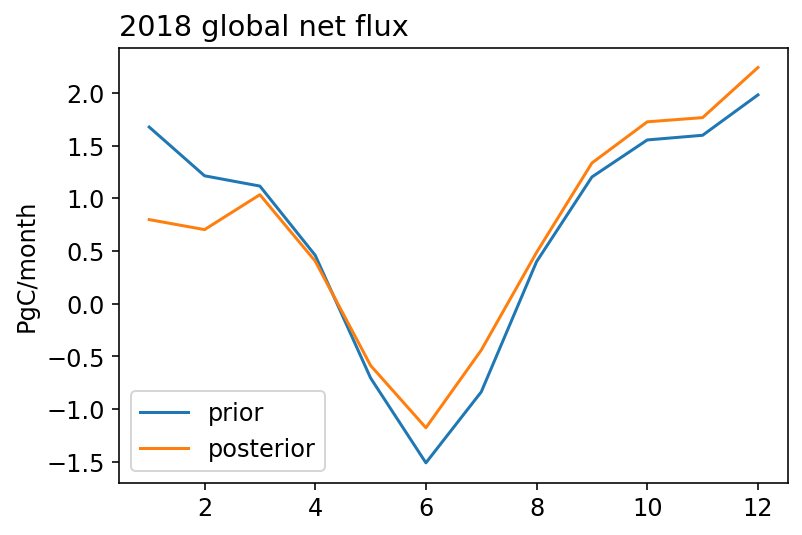

In [206]:
fig = plt.figure(figsize=[6, 4])
plt.plot(range(1,13), net_flux_2018, label = 'prior')
plt.plot(range(1,13), adjusted, label = 'posterior')
plt.title('2018 global net flux', loc='left')
plt.ylabel('PgC/month')
#plt.ylim(-2,2)
plt.legend()

fig.savefig('/geos/u73/msadiq/GEOS-Chem/analysis/inversion/data/monthly_posterior.png', dpi = 300)


In [207]:
#fig = plt.figure(figsize=[6, 4])
#plt.plot(range(1,13), monthly_adjustment, label = 'adjustment')
#plt.title('2018 global net flux', loc='left')
#plt.ylabel('PgC/month')
#plt.legend()